In [23]:
import sys
import os
import gc
import itertools as it
import tempfile
from collections import Counter, namedtuple
import multiprocessing as mp
import datetime as dt


import numpy as np
import pandas as pd

from joblib import Parallel, delayed, cpu_count, load, dump, Memory

%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
df = pd.read_pickle("data/train_vs_test.pkl")

In [25]:
df

,b261,b262,b263,b264,b278
b261,NaN,0.771084,0.760234,0.784158,0.708333
b262,0.821159,NaN,0.769826,0.793774,0.736390
b263,0.839506,0.800000,NaN,0.844278,0.746518
b264,0.829630,0.786389,0.795497,NaN,0.744382
b278,0.835000,0.817326,0.778828,0.803089,NaN


In [27]:
df.mean(axis=1)

b261    0.755953
b262    0.780287
b263    0.807575
b264    0.788975
b278    0.808561
dtype: float64

In [4]:
# corral startup
sys.path.insert(1, "/home/jbcabral/carpyncho3")
os.environ.setdefault("CORRAL_SETTINGS_MODULE", "carpyncho.settings")

from corral import core
core.setup_environment()

from corral import db
from carpyncho.models import *

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
mjds = {}
with db.session_scope() as session:
    for tname in df.index:
        print tname
        pxts = session.query(PawprintStack.mjd).join(PawprintStackXTile).filter(PawprintStackXTile.tile.has(name=tname))
        mjds[tname] = np.sort(np.array([pxt[0] for pxt in pxts.all()]))

[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,800] select version()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,801] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,806] select current_schema()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,808] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,812] SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,814] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,818] SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,819] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,824] show standard_conforming_strings
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,826] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:28:18,830] BEGIN (imp

b261
b262
b263
b264
b278


In [6]:
epochs = {k: len(v) for k, v in mjds.items()}
epochs

{'b261': 371, 'b262': 372, 'b263': 514, 'b264': 515, 'b278': 342}

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def compute(aname, bname):
    a, b = mjds[aname], mjds[bname]
    if len(a) > len(b):
        a, b = b, a
    to_diff = np.array([find_nearest(b, i) for i in a])
    return np.abs(a - to_diff).mean()

In [8]:
columns = list(df.columns)

In [9]:
df.loc[:,'b261_md'] = pd.Series(np.array([compute(name, "b261") for name in columns]), index=df.index)
df.loc[:,'b262_md'] = pd.Series(np.array([compute(name, "b262") for name in columns]), index=df.index)
df.loc[:,'b263_md'] = pd.Series(np.array([compute(name, "b263") for name in columns]), index=df.index)
df.loc[:,'b264_md'] = pd.Series(np.array([compute(name, "b264") for name in columns]), index=df.index)
df.loc[:,'b278_md'] = pd.Series(np.array([compute(name, "b278") for name in columns]), index=df.index)

In [11]:
columns = list(df.columns)
columns.sort()

In [12]:
df = df[columns]

In [13]:
df

,b261,b261_md,b262,b262_md,b263,b263_md,b264,b264_md,b278,b278_md
b261,NaN,0.000000,0.771084,0.034503,0.760234,2.339552,0.784158,2.415895,0.708333,36.403409
b262,0.821159,0.034503,NaN,0.000000,0.769826,2.309310,0.793774,2.418570,0.736390,36.457655
b263,0.839506,2.339552,0.800000,2.309310,NaN,0.000000,0.844278,0.083686,0.746518,9.558696
b264,0.829630,2.415895,0.786389,2.418570,0.795497,0.083686,NaN,0.000000,0.744382,9.557587
b278,0.835000,36.403409,0.817326,36.457655,0.778828,9.558696,0.803089,9.557587,NaN,0.000000


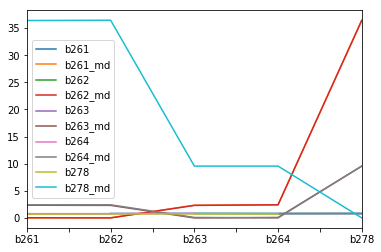

In [18]:
mjds = {}
with db.session_scope() as session:
    for t in session.query(Tile):
        print t
        pxts = session.query(PawprintStack.mjd).join(PawprintStackXTile).filter(PawprintStackXTile.tile.has(name=t.name))
        mjds[t.name] = np.sort(np.array([pxt[0] for pxt in pxts.all()]))

[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:38:08,318] BEGIN (implicit)
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:38:08,321] SELECT "Tile".raw_filename AS "Tile_raw_filename", "Tile".npy_filename AS "Tile_npy_filename", "Tile".id AS "Tile_id", "Tile".name AS "Tile_name", "Tile".size AS "Tile_size", "Tile".status AS "Tile_status", "Tile".ogle3_tagged_number AS "Tile_ogle3_tagged_number", "Tile".ready AS "Tile_ready" 
FROM "Tile"
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:38:08,323] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:38:08,331] SELECT "PawprintStack".mjd AS "PawprintStack_mjd" 
FROM "PawprintStack" JOIN "PawprintStackXTile" ON "PawprintStack".id = "PawprintStackXTile".pawprint_stack_id 
WHERE EXISTS (SELECT 1 
FROM "Tile" 
WHERE "Tile".id = "PawprintStackXTile".tile_id AND "Tile".name = %(name_1)s)
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-22 14:38:08,333] {'name_1': u'b262'}
[carpyncho-sqlalchemy.

<Tile 'b262'>
<Tile 'b263'>
<Tile 'b261'>
<Tile 'b264'>
<Tile 'b278'>
<Tile 'b220'>
<Tile 'b410'>
<Tile 'b437'>
<Tile 'b396'>


In [22]:
{k: (v.mean(), v.std()) for k, v in mjds.items() if not k.startswith("b4")}

{u'b220': (56386.577573654104, 390.02629976663746),
 u'b261': (56354.809640219508, 381.51638502332219),
 u'b262': (56357.238610203705, 383.79596313898287),
 u'b263': (56450.74349398187, 422.09062791300931),
 u'b264': (56451.204669857245, 421.4903623614004),
 u'b278': (56404.879761224212, 449.74635756473936),
 u'b396': (56401.087239206885, 406.41134792184477)}